#**Single Layer Neural Network: 단일층 신경망**

일반적인 신경망은 '입력층' -> '은닉층' -> '출력층' 의 구조로 이루어져 있다.

앞에서 구현한 LogisticNeuron은 이미 단일층 신경망 역할을 수행할 수 있다.

뉴런(유닛)은 여러 번(여러 에포크) 반복 학습하면서 **손실함수 값을 최소화**하여 오차를 줄여나간다.

이번에는 실제로 손실함수의 값이 줄어는지 관찰할 수 있는 기능 등을 넣어   
LogisticNeuron을 개선해보자.

In [ ]:
# 데이터셋 로드 및 분할

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data, test_data, train_target, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)

###**손실함수 결과값 저장 기능**

 1. \_\_init__() 메서드에 손실함수 값을 저장할 losses 리스트를 만든다.
 2. 샘플마다 손실함수를 계산하고 losses에 값을 추가한다.
 3. activation() 메서드로 계산한 a는 np.log() 계산을 위해 한 번 더 조정한다.
    > a가 0에 가까워지면 로그값은 음의 무한대가 되고, a가 1에 가까워지면 로그값은 0이 되기 때문이다.
 4. np.random.permutation()과 indexes를 이용해 샘플을 무작위로 섞어서 fitting을 진행한다.
 5. 예측함수에서 활성화 함수를 대신해 계단함수를 적용한다.
 6. score() 평가 함수를 추가한다.


In [ ]:
class SingleLayer:

  def __init__(self):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []

  def forpass(self, x):
    z = np.sum(self.w * x) + self.b   # x와 w는 1차원 배열이므로 np.sum을 이용해 모든 요소를 다 더한다.
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    w_grad = x * err
    b_grad = err
    return w_grad, b_grad


  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])  # 가중치와 절편 초기화
    self.b = 0
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 샘플 개수만큼의 인덱스 섞기
      for i in indexes:
        z = self.forpass(x[i])   # 정방향 계산
        a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
        err =  -(y[i] - a)       # 활성화 함수를 거친 a값으로 오차량 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 오차역전파
        self.w -= w_grad   # 그레이디언트 업데이트
        self.b -= b_grad
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append(loss/len(y))


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y)

#**SingleLayer 훈련하기**

In [ ]:
layer = SingleLayer()
layer.fit(train_data, train_target)
layer.score(test_data, test_target)

0.9473684210526315

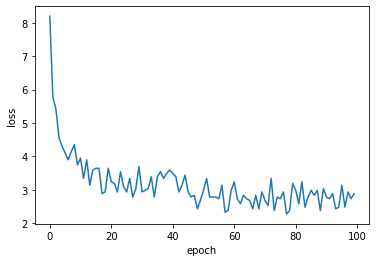

In [ ]:
plt.plot(layer.losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

>**실제로 매 에포크가 진행됨에 따라 손실함수 값이 줄어드는 것을 볼 수 있다.**

#**Sklearn SGDClassifier 사용하기**

경사하강법이 구현된 클래스를 사이킷런에서 제공하고 있다.
sklearn의 SGDClassifier을 통해 회귀 문제를 해결해보자.

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)
'''
  SGDClassifier에 로지스틱 회귀를 적용하기 위해서는 'loss' 파라미터에 'log'를 취해준다.
  max_iter는 반복 횟수이다.
  tol은 매 반복마다 손실함수 값이 감소해야 하는 양을 지정한다.
     -> 매 반복마다 tol에 지정한 값만큼 손실함수 값이 감소하지 않으면 반복을 중단한다.
     -> tol값을 지정하지 않으면 max_iter를 늘리라는 경고를 한다.
  random_state는 책과 실습의 동일한 결과를 위해 난수 초기값 42로 지정한다.
'''

"\n  SGDClassifier에 로지스틱 회귀를 적용하기 위해서는 'loss' 파라미터에 'log'를 취해준다.\n  max_iter는 반복 횟수이다.\n  tol은 매 반복마다 손실함수 값이 감소해야 하는 양을 지정한다.\n     -> 매 반복마다 tol에 지정한 값만큼 손실함수 값이 감소하지 않으면 반복을 중단한다.\n     -> tol값을 지정하지 않으면 max_iter를 늘리라는 경고를 한다.\n  random_state는 책과 실습의 동일한 결과를 위해 난수 초기값 42로 지정한다.\n"

In [ ]:
sgd.fit(train_data, train_target)   # fitting
sgd.score(test_data, test_target)   # 성능 평가

0.8333333333333334